# Эксперименты на реальных данных, сравнение моделей

In [1]:
import numpy as np
import igraph as ig
import scipy as sp
import scipy.spatial as spatial
import matplotlib.pyplot as plt
import networkx as nx
import cPickle
from Extends import *
import subprocess
import os
from big_clam import BigClam
from big_clam_gamma import BigClamGamma
from Experiments import *
from time import gmtime, strftime
from collections import defaultdict
from cPickle import dump, load
def time():
    return strftime("%H:%M:%S ", gmtime())
%matplotlib inline 

In [2]:
from sklearn.decomposition import NMF

In [3]:
def NMF_clust(A, K):
    model = NMF(n_components=K)
    res = model.fit_transform(A)
    #print res.shape
    return res

In [4]:
import networkx as nx
from collections import defaultdict

def get_percolated_cliques(G, k):
    perc_graph = nx.Graph()
    cliques = [frozenset(c) for c in nx.find_cliques(G) if len(c) >= k]
    perc_graph.add_nodes_from(cliques)

    # First index which nodes are in which cliques
    membership_dict = defaultdict(list)
    for clique in cliques:
        for node in clique:
            membership_dict[node].append(clique)

    # For each clique, see which adjacent cliques percolate
    for clique in cliques:
        for adj_clique in get_adjacent_cliques(clique, membership_dict):
            if len(clique.intersection(adj_clique)) >= (k - 1):
                perc_graph.add_edge(clique, adj_clique)

    # Connected components of clique graph with perc edges
    # are the percolated cliques
    for component in nx.connected_components(perc_graph):
        yield(frozenset.union(*component))

def get_adjacent_cliques(clique, membership_dict):
    adjacent_cliques = set()
    for n in clique:
        for adj_clique in membership_dict[n]:
            if clique != adj_clique:
                adjacent_cliques.add(adj_clique)
    return adjacent_cliques

# Генерация модельных примеров

In [5]:
seed = 21773222
data_params = {
    'N': 1000,
     'mut': 0.1,
     'maxk': 50,
     'k': 30,
     'om': 2,
     'muw': 0.1,
     'beta': 2,
     't1': 2,
     't2': 2,
     'on': 0,
     }

iter_count = 1
mixing_range = np.linspace(0, 0.5, 6)

model_params = {
    'initF':'cond_new_randz', 
    'LLH_output':False, 
    'iter_output':20000, 
    'processesNo':4, 
    'dump':10,
    'eps':1e-2,
    "max_iter":500000,
    'sparsity_coef': 5,
}

In [6]:
models = {#'BigClam-Zeros': lambda A, K, name: BigClam(1.0 * (A != 0), K, dump_name=name, **model_params).fit()[0],
          #'BigClam-Zeros-simple': lambda A, K, name: BigClam(1.0 * (A != 0), K, dump_name=name, stepSizeMod='simple', **model_params).fit()[0],
          #'BigClam-Mean': lambda A, K, name: BigClam(1.0 * (A < np.mean(A)), K, dump_name=name, **model_params).fit()[0],
          'BigClamWeighted': lambda A, K, name: BigClam(A, K, dump_name=name,**model_params).fit()[0],
          'SparseGamma': lambda A, K, name: BigClamGamma(A, K, dump_name=name, **model_params).fit()[0],
          'BigClam-orig-zeros': lambda A, K, name: bigclam_orig(1.0 * (A != 0), K),
          #'BigClam-orig-mean': lambda A, K, name: bigclam_orig(1.0 * (A < np.mean(A)), K),
          'COPRA': lambda A, K, name: copra(A,K),
          'NMF': lambda A, K, name: NMF_clust(A,K),
          #'CPM': lambda A, K, name: [list(x) for x in get_percolated_cliques(nx.from_numpy_matrix(1.0 * (A != 0)), 5)]
        }

qual_fun = {'MixedModularity': MixedModularity,
            '1-MeanConductance': lambda F,A: 1-MeanConductance(GetComms(F, A), A) if not isinstance(F, list) else 1-MeanConductance(F, A),
            '1-MaxConductance': lambda F,A: 1-MaxConductance(GetComms(F, A), A) if not isinstance(F, list) else 1-MaxConductance(F, A),
            'NMI': lambda F,A, true_comm: NMI(GetComms(F, A), A, true_comm) if not isinstance(F, list) else NMI(F, A, true_comm),
            #'NMI_new': lambda F,A, true_comm: NMI3(GetComms(F, A), A, true_comm) if not isinstance(F, list) else NMI(F, A, true_comm),
            }

In [7]:
models_res = []

for i_mix, mix in enumerate(mixing_range):
    print '{} mix: {}'.format(time(), mix)
    with file(r'..\external\Lancichinetti benchmark\time_seed.dat', 'w') as f:
        f.write(str(seed))
    data_params['on'] = np.floor(data_params['N'] * mix)
    one_graph_res = {name: {key: [] for key in qual_fun} for name in models}
    for iter in xrange(iter_count):
        print ' {}:'.format(iter),
        G, comms = LancichinettiBenchmark(**data_params)
        A = np.array(nx.to_numpy_matrix(G))
        for name in models:
            print name, 
            F = models[name](A, len(comms), name)
            for key in qual_fun:
                if key not in  {"NMI", 'NMI_new'}:
                    res = qual_fun[key](F, A)
                else: 
                    res = qual_fun[key](F, A, comms)
                one_graph_res[name][key].append(res)
        if iter != iter_count-1:
            print '\r' + ' '*100 + '\r',
        else:
            print 
    models_res.append(one_graph_res)
    dump((models_res, mixing_range, mix, data_params), file('../data/dumps/models_res_temp-{}-dump'.format(i_mix), 'w'))
dump((models_res, mixing_range, mix, data_params), file('../data/dumps/models_res_full-dump', 'w'))


15:53:22  mix: 0.0
 0: SparseGamma BigClamWeighted NMF COPRA BigClam-orig-zeros
15:54:28  mix: 0.1
 0: SparseGamma BigClamWeighted NMF COPRA BigClam-orig-zeros
15:55:40  mix: 0.2
 0: SparseGamma BigClamWeighted NMF COPRA BigClam-orig-zeros
15:56:57  mix: 0.3
 0: SparseGamma BigClamWeighted NMF COPRA BigClam-orig-zeros
15:58:11  mix: 0.4
 0: SparseGamma BigClamWeighted NMF COPRA BigClam-orig-zeros
15:59:40  mix: 0.5
 0: SparseGamma BigClamWeighted NMF COPRA BigClam-orig-zeros


In [17]:
(models_res, mixing_range, mix, data_params) = load(file('../data/dumps/models_res_full-dump'))

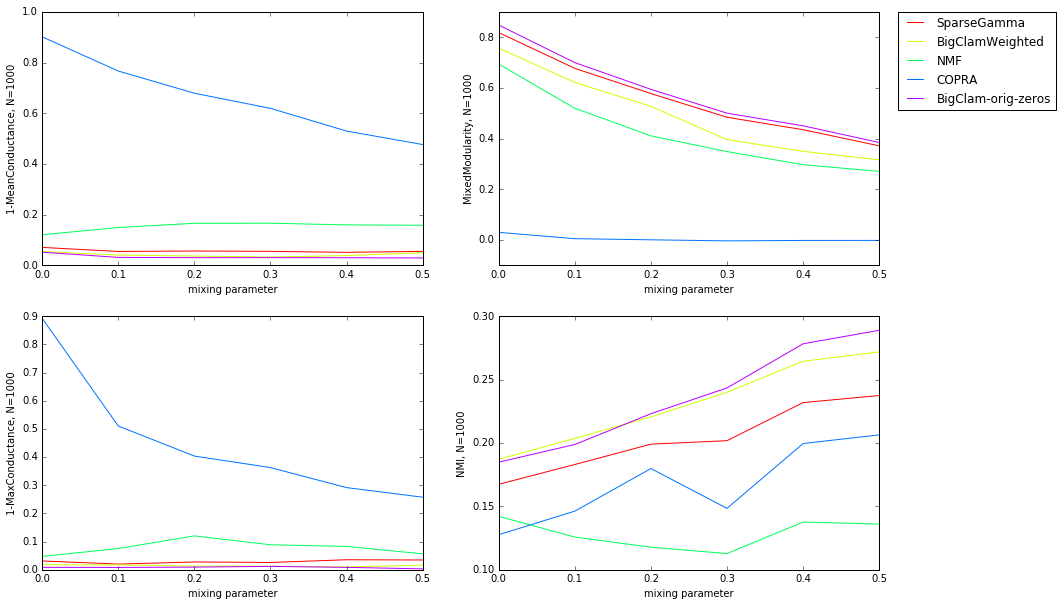

In [8]:
def mean(l):
    return 1.0 * sum(l) / len(l)

plt.figure(figsize=(15,10))
for indx, qual_name in enumerate(qual_fun):
    plt.subplot(2,len(qual_fun)/2, indx+1)
    plt.ylabel('{}, N={}'.format(qual_name, data_params['N']))
    plt.xlabel('mixing parameter')
    colors = plt.get_cmap('hsv')(np.linspace(0, 1.0, len(models)+1))
    for i, name in enumerate(models):
        plt.plot(mixing_range, [res[name][qual_name][0] for res in models_res if len(res) != 0], label=name, color=colors[i])
    if indx == 1:
        plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

In [43]:
models_res

[{'BigClamWeighted': {'1-MaxConductance': [0.0],
   '1-MeanConductance': [0.068431824848386613],
   'MixedModularity': [0.37256514870252722],
   'NMI': [0.320706]},
  'COPRA': {'1-MaxConductance': [0.0],
   '1-MeanConductance': [0.74292019121244601],
   'MixedModularity': [0.084414916633870393],
   'NMI': [0.425404]},
  'SparseGamma': {'1-MaxConductance': [0.0066666666666667096],
   '1-MeanConductance': [0.12398302537533434],
   'MixedModularity': [0.19961505539041316],
   'NMI': [0.362497]}}]

In [8]:
models_res[-2].keys()

['SparseGamma', 'BigClamWeighted', 'BigClam-Zeros']

In [28]:
res[name][qual_name]

KeyError: 'SparseGamma'

In [29]:
res

{}

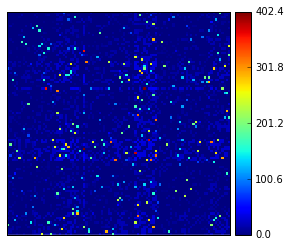

In [43]:
draw_matrix(A)

# REAL

In [47]:
s = 0
import os
DATA_PATH = '../data/weighted/'
gml_paths = [f for f in os.listdir(DATA_PATH) if f.endswith(".gml")]
Fss = []
LLHs = []

res = {'LLH':None, 'F': None, 'Model':None}
K = {'lesmis.gml': 8, 'netscience.gml': 300}
params = {
    'initF':'cond_new_randz_spr', 
    'LLH_output':True, 
    'iter_output':20000, 
    'processesNo':4, 
    'dump':10,
    'eps':1e-4,
    "max_iter":500000
}

models = {'BigClam-Zeros': lambda A, K, name: BigClam(1.0 * (A != 0), K, dump_name=name, **params),
          'BigClam-Zeros-s': lambda A, K, name: BigClam(1.0 * (A != 0), K, dump_name=name, stepSizeMod='simple', **params),
          #'BigClam-Mean': lambda A: BigClam(1.0 * (A < np.mean(A))),
          #'BigClamWeighted': lambda A: BigClam(A),
          'SparseGamma': lambda A, K, name: BigClamGamma(A, K, dump_name=name, **params),
          'SparseGamma-005': lambda A, K, name: BigClamGamma(A, K, dump_name=name, pow=0.05, **params),
          'SparseGamma-0005': lambda A, K, name: BigClamGamma(A, K, dump_name=name, pow=0.005, **params),
          'SparseGamma-1': lambda A, K, name: BigClamGamma(A, K, dump_name=name, pow=1, **params),
         }

models_res_all = []

for ego in gml_paths:
    G = nx.read_gml(file(DATA_PATH + '{}'.format(ego)))
    A = np.array(nx.to_numpy_matrix(G))
    models_res = {}
    print '{} data, {} nodes, {} edges'.format(ego, len(G), nx.number_of_edges(G))
    for key in models:
        print "    " + key + ' model...'
        model = models[key](A, K[ego], key+ '_' + ego + '.dump')
        res = model.fit()
        models_res[key] = {'LLH':model.LLH_output, 'F': res[0], 'Model':model, "A":A}
    models_res_all.append(models_res)

lesmis.gml data, 77 nodes, 254 edges
    SparseGamma model...
    BigClam-Zeros-s model...
iter: 20000, LLH:-528.849244148
iter: 40000, LLH:-484.940410099
    BigClam-Zeros model...
    SparseGamma-1 model...
    SparseGamma-0005 model...
    SparseGamma-005 model...
netscience.gml data, 1589 nodes, 2742 edges
    SparseGamma model...
iter: 20000, LLH:-21767.247434
iter: 40000, LLH:-19687.6628627
iter: 60000, LLH:-18937.2193348
iter: 80000, LLH:-18516.7589119
iter: 100000, LLH:-18229.3449533
iter: 120000, LLH:-18008.4661095
iter: 140000, LLH:-17828.6474769
iter: 160000, LLH:-17680.3964621
iter: 180000, LLH:-17555.1005005
iter: 200000, LLH:-17447.1678228
iter: 220000, LLH:-17354.1563769
iter: 240000, LLH:-17272.1305246
iter: 260000, LLH:-17199.4121813
iter: 280000, LLH:-17134.1125803
iter: 300000, LLH:-17075.3498498
iter: 320000, LLH:-17022.6379142
iter: 340000, LLH:-16974.6675253
iter: 360000, LLH:-16931.0007494
iter: 380000, LLH:-16890.3780454
iter: 400000, LLH:-16852.663176
iter: 420

In [5]:
os.getcwd()

'D:\\YandexDisk\\projects\\data Mining and science problems\\MMOS\\BigClam_2\\code'

In [44]:
def nx2ig(G):
    Gnew = ig.Graph()
    Gnew.add_vertices(G.nodes())
    Gnew.add_edges(G.edges())
    return Gnew

def NMI(F, A):
    C = F > np.sum(A) / (np.mean(A[A!=0]) * A.shape[0] * (A.shape[0] - 1))
    G = igraph.Weighted_Adjacency(A)
    

In [52]:
indx = 0

G = nx.read_gml(file(DATA_PATH + '{}'.format(gml_paths[indx])))
A = np.array(nx.to_numpy_matrix(G))

print MixedModularity(models_res_all[indx]['SparseGamma']['F'], A)
print MixedModularity(models_res_all[indx]['SparseGamma-1']['F'], A)
print MixedModularity(models_res_all[indx]['SparseGamma-005']['F'], A)
print MixedModularity(models_res_all[indx]['SparseGamma-0005']['F'], A)
print MixedModularity(models_res_all[indx]['BigClam-Zeros']['F'], A)
print MixedModularity(models_res_all[indx]['BigClam-Zeros-s']['F'], A)

0.331381542878
0.355067307527
0.239777749248
0.0609159994471
0.272450369312
0.387401347012


In [51]:
2 * np.sum(A) / (A.shape[0]*(A.shape[0]-1) )

0.0043466337366624766

['SparseGamma', 'BigClam-Zeros']


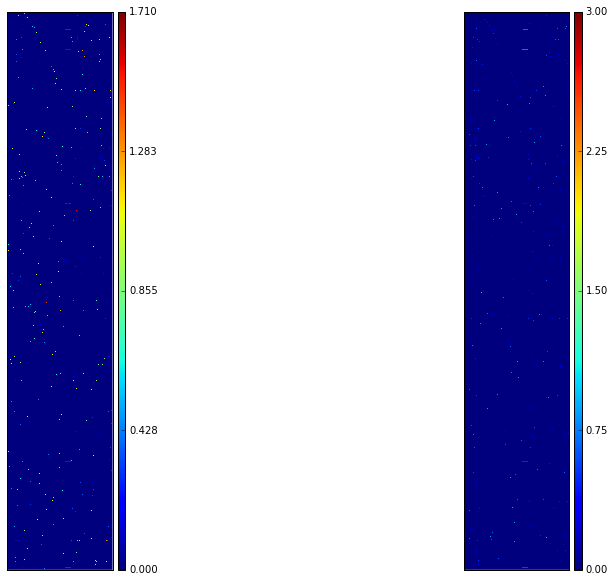

In [16]:
print models_res_all[0].keys()
plt.figure(figsize=(15,10))
plt.subplot(121)
draw_matrix(models_res_all[1]['SparseGamma']['F'])
plt.subplot(122)
draw_matrix(models_res_all[1]['BigClam-Zeros']['F'])

[ 1.  1.  1.  2.  1.  1.  1.]
24.0
[ True  True  True  True False False False]
[[3]
 [3]
 [3]
 [6]]
[[0 1 1 1]
 [1 0 1 1]
 [1 1 0 1]
 [1 1 1 0]]
[[-0.375  0.625  0.625  0.25 ]
 [ 0.625 -0.375  0.625  0.25 ]
 [ 0.625  0.625 -0.375  0.25 ]
 [ 0.25   0.25   0.25  -1.5  ]]
[[ 1.    1.    1.    0.5 ]
 [ 1.    1.    1.    0.5 ]
 [ 1.    1.    1.    0.5 ]
 [ 0.5   0.5   0.5   0.25]]
[[-0.375  0.625  0.625  0.125]
 [ 0.625 -0.375  0.625  0.125]
 [ 0.625  0.625 -0.375  0.125]
 [ 0.125  0.125  0.125 -0.375]]
[False False False  True  True  True  True]
[[6]
 [3]
 [3]
 [3]]
[[0 1 1 1]
 [1 0 1 1]
 [1 1 0 1]
 [1 1 1 0]]
[[-1.5    0.25   0.25   0.25 ]
 [ 0.25  -0.375  0.625  0.625]
 [ 0.25   0.625 -0.375  0.625]
 [ 0.25   0.625  0.625 -0.375]]
[[ 0.25  0.5   0.5   0.5 ]
 [ 0.5   1.    1.    1.  ]
 [ 0.5   1.    1.    1.  ]
 [ 0.5   1.    1.    1.  ]]
[[-0.375  0.125  0.125  0.125]
 [ 0.125 -0.375  0.625  0.625]
 [ 0.125  0.625 -0.375  0.625]
 [ 0.125  0.625  0.625 -0.375]]
0.25


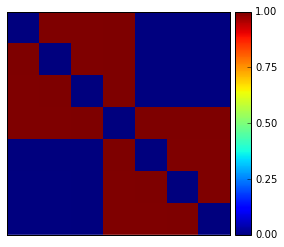

In [125]:
F = np.array([[1.,1.,1.,1.,0.,0.,0.], [0.,0.,0.,1.,1.,1.,1.]]).T
At = test_example()
draw_matrix(At)
print MixedModularity(F, At)

# Модельные данные. Обзор

In [19]:
G, comms = LancichinettiBenchmark(N=1000)

In [30]:
pos=nx.spring_layout(G)
print 'Pos!'

Pos!


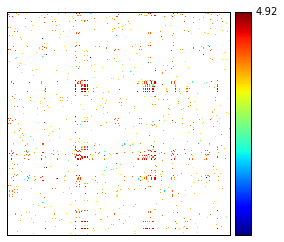

In [31]:
draw_matrix(np.log(nx.to_numpy_matrix(G)))

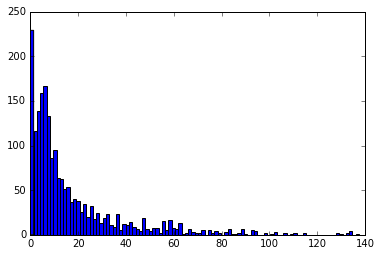

In [32]:
plt.hist([e[2]['weight'] for e in G.edges(data=True)], 100)
pass

In [33]:
len(comms)

28

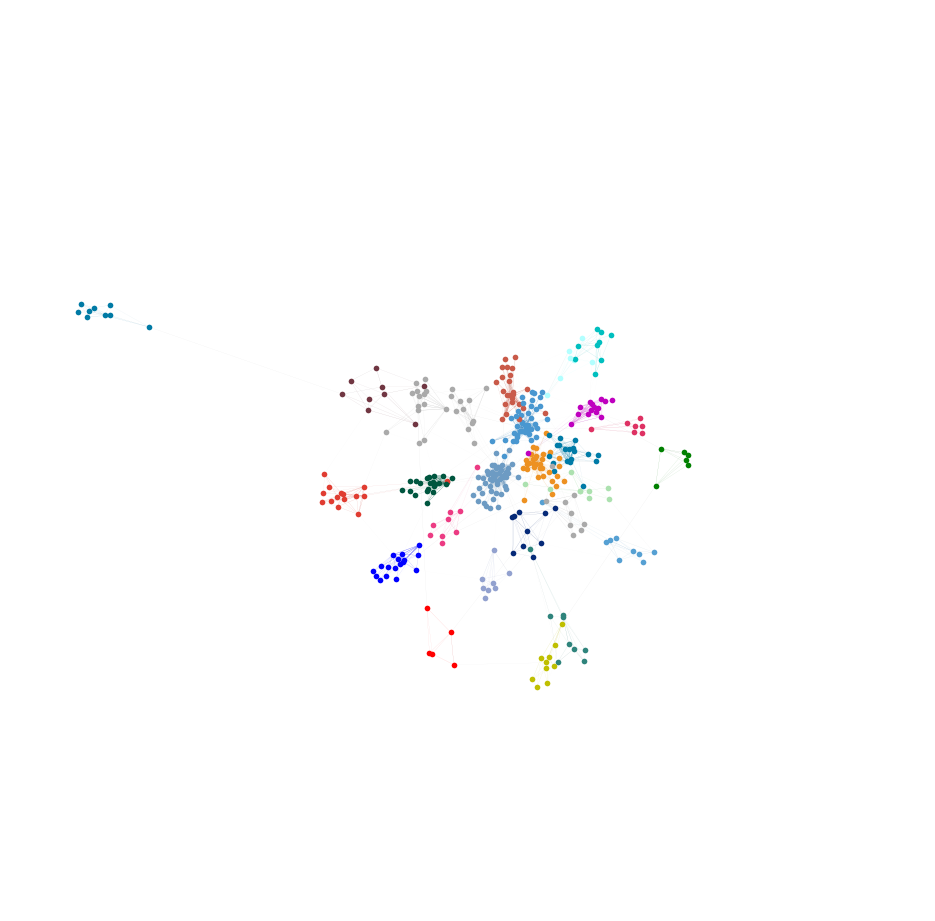

In [38]:
size = 16
ax = plt.figure(figsize=(size, size))
#nx.draw_networkx(G_test, pos=pos, node_size=25, alpha=0.3, linewidths=0, width=0.5, with_labels=False)
max_w = max(e[2]['weight'] for e in G.edges(data=True))

node_size = 2 * size
drawn = []
for col_i, i in enumerate(comms):
    G_part = nx.subgraph(G, comms[i])
    width = [2 * e[2]['weight'] / max_w for e in G_part.edges(data=True)]
    edgelist = list(G_part.edges())
    nx.draw_networkx_edges(G, pos, edgelist=edgelist, width=width, alpha=0.5, edge_color=col[col_i if col_i < len(col) else -1])
    drawn.extend(edgelist)
nx.draw_networkx_edges(G, pos, edgelist= [x for x in G.edges() if x not in drawn], width=width, alpha=0.1)
nx.draw_networkx_nodes(G, pos, node_color='#FFFFFF', node_size=node_size, alpha=1, linewidths=0)
if len(comms) > len(col):
    print 'WARNING: too low colors count'
for j in G:
    node_cols = [(col_i if col_i < len(col) else -1) for col_i, i in enumerate(comms) if j in comms[i]]
    for k, col_i in enumerate(node_cols):
        nx.draw_networkx_nodes(G, pos, nodelist=[j], node_color=col[col_i], node_size=(len(node_cols)-k) * node_size,
                               alpha=1, linewidths=0, width=0.3, with_labels=False)

bord = 0.5
plt.xlim([-bord, bord])
plt.ylim([-bord, bord])
plt.axis('off')
pass